## Mounting Google Drive and Loading Data

First, let's mount the Google Drive to access the preprocessed data. Ensure that your data files are stored in the correct path within your Google Drive.

In [1]:
# Mounting your Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import pandas as pd

# Import your training and validation data
# Replace 'path_to_data' with the actual path of your data in Google Drive
data_path = 'd:/DATA/2023-10_opencampus_Data_Science/gruppe3/csv_df_neural_net/'
training_features = pd.read_csv(f'{data_path}/training_features.csv')
training_labels = pd.read_csv(f'{data_path}/training_labels.csv')
validation_features = pd.read_csv(f'{data_path}/validation_features.csv')
validation_labels = pd.read_csv(f'{data_path}/validation_labels.csv')
test_features = pd.read_csv(f'{data_path}/test_features.csv')
test_labels = pd.read_csv(f'{data_path}/test_labels.csv')


## Defining the Neural Network

Now, let's define our neural network. We are using a Sequential model definition from Keras with batch normalization and dense layers.

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
  InputLayer(input_shape=(training_features.shape[1], )),
  BatchNormalization(),
  Dense(12, activation='relu'),
  Dropout(0.3),
  Dense(4, activation='relu'),
  Dropout(0.8),
  Dense(1)
])

model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 39)                156       
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 12)                480       
                                                                 
 dropout (Dropout)           (None, 12)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 52        
                                                                 
 dropout_1 (Dropout)         (None, 4)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                      

## Compiling and Training the Model

We will compile the model using Mean Squared Error (MSE) as the loss function and Adam optimizer. The model is then trained using the training data.

In [4]:
model.compile(loss="mse", optimizer=Adam(learning_rate=0.001))

history = model.fit(training_features, training_labels, epochs=200,
                    validation_data=(validation_features, validation_labels))

Epoch 1/200

235/235 [==============================] - 3s 4ms/step - loss: 52942.5391 - val_loss: 48548.6523
Epoch 2/200
235/235 [==============================] - 1s 3ms/step - loss: 44972.6367 - val_loss: 35469.9414
Epoch 3/200
235/235 [==============================] - 1s 3ms/step - loss: 41656.1445 - val_loss: 34218.2969
Epoch 4/200
235/235 [==============================] - 1s 3ms/step - loss: 41243.0625 - val_loss: 33842.6406
Epoch 5/200
235/235 [==============================] - 1s 3ms/step - loss: 40507.5039 - val_loss: 33800.1602
Epoch 6/200
235/235 [==============================] - 1s 3ms/step - loss: 40664.8711 - val_loss: 33820.0859
Epoch 7/200
235/235 [==============================] - 1s 3ms/step - loss: 39924.8477 - val_loss: 33731.1836
Epoch 8/200
235/235 [==============================] - 1s 3ms/step - loss: 40235.1523 - val_loss: 33371.1602
Epoch 9/200
235/235 [==============================] - 1s 3ms/step - loss: 40135.0508 - val_loss: 33629.2422
Epoch 10/200
235/2

## Saving the Trained Model

After training, it's a good practice to save the model for future use.

In [5]:
model.save("python_model.h5")

C:\Prog\anaconda3\envs\tf\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Plotting Training History

Visualizing the training and validation loss can help us understand the model's performance over time.

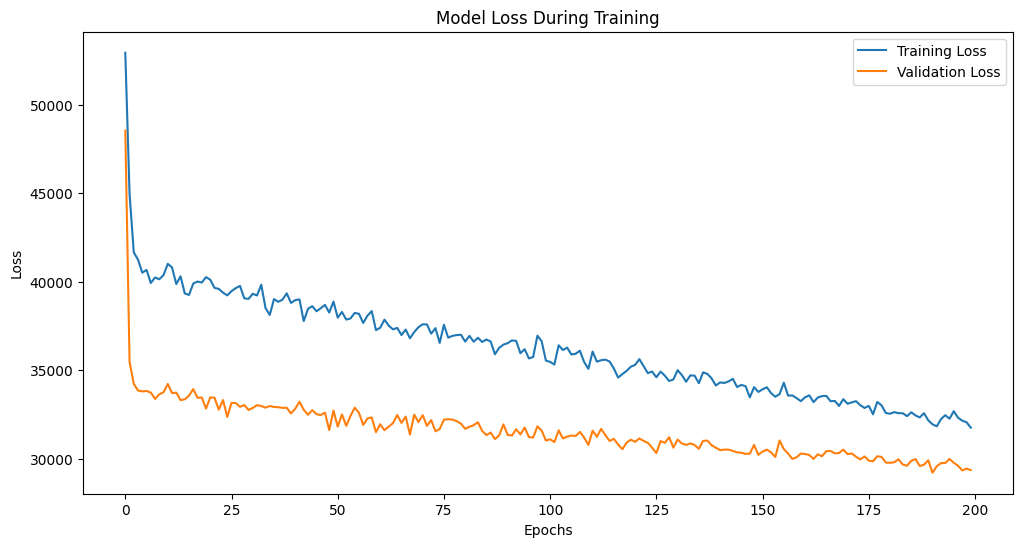

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Making Predictions and Evaluating the Model

Let's use the model to make predictions on our training and validation sets and evaluate the model's performance using Mean Absolute Percentage Error (MAPE).

In [7]:
import numpy as np

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

training_predictions = model.predict(training_features)
validation_predictions = model.predict(validation_features)
training_predictions
print(f"MAPE on the Training Data: {mape(training_labels, training_predictions):.2f}%")
print(f"MAPE on the Validation Data: {mape(validation_labels, validation_predictions):.2f}%")


58/58 [==============================] - 0s 2ms/step
MAPE on the Training Data: 48.28%
MAPE on the Validation Data: 50.13%


In [19]:
def mape_by_group(y_true, y_pred, groups):
    """
    Calculate MAPE for each product group separately.

    Parameters:
    - y_true: array-like, true values
    - y_pred: array-like, predicted values
    - groups: DataFrame, one-hot encoded product group columns
    created by Chat-GPT
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)

    group_mapes = []
    for group_column in groups.columns:
        group_mask = groups[group_column] == 1
        group_true = y_true[group_mask]
        group_pred = y_pred[group_mask]

        non_zero_mask = group_true != 0
        group_mape = np.mean(np.abs((group_true[non_zero_mask] - group_pred[non_zero_mask]) / group_true[non_zero_mask])) * 100
        group_mapes.append(group_mape)

    return np.array(group_mapes)

# Assuming you have product group columns like 'as.factor(product_group)1', 'as.factor(product_group)2', ...
product_group_columns = [col for col in validation_features.columns if 'as.factor(Warengruppe)' in col]

product_groups = validation_features[product_group_columns]

validation_predictions = model.predict(validation_features)

mape_by_group_array = mape_by_group(validation_labels, validation_predictions, product_groups)

# Print MAPE for each product group
for i, mape_value in enumerate(mape_by_group_array):
    print(f"MAPE for Warengruppe {i+2}: {mape_value:.2f}%")

# Print overall MAPE
print(f"Overall MAPE on the Validation Data: {np.mean(mape_by_group_array):.2f}%")

58/58 [==============================] - 0s 2ms/step
MAPE for Warengruppe 2: 48.91%
MAPE for Warengruppe 3: 46.07%
MAPE for Warengruppe 4: 51.09%
MAPE for Warengruppe 5: 52.11%
MAPE for Warengruppe 6: 54.90%
Overall MAPE on the Validation Data: 50.62%


## Visualizing Predictions vs Actual Values

Visualizing the predicted versus actual values can provide insights into the model's accuracy.

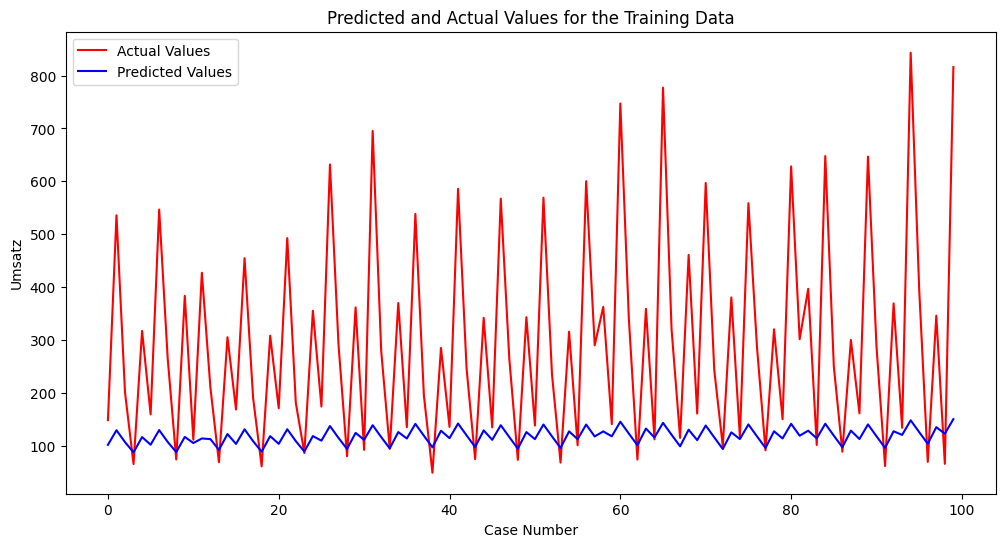

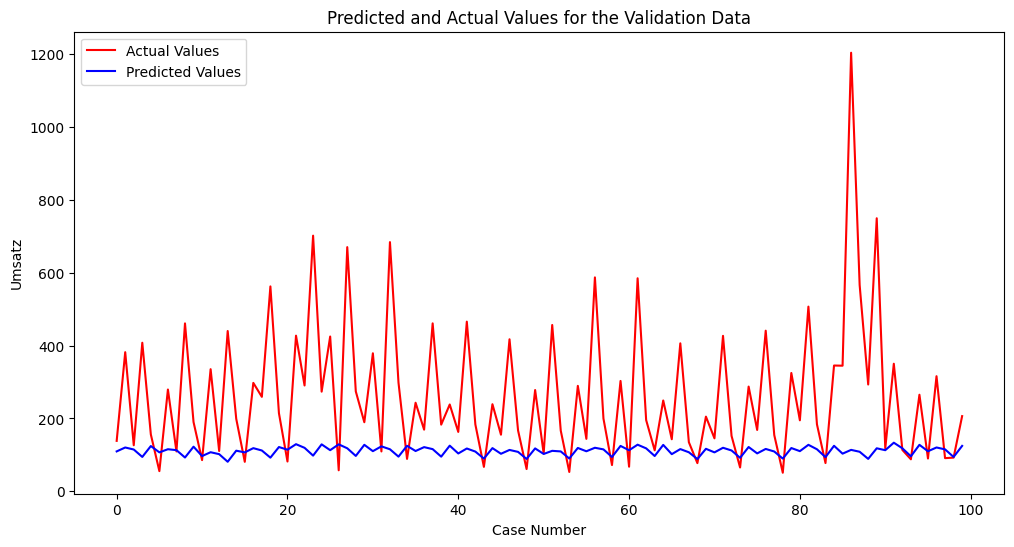

In [8]:
def plot_predictions(data, title):
    plt.figure(figsize=(12, 6))
    plt.plot(data['actual'], label='Actual Values', color='red')
    plt.plot(data['prediction'], label='Predicted Values', color='blue')
    plt.title(title)
    plt.xlabel('Case Number')
    plt.ylabel('Umsatz')
    plt.legend()
    plt.show()

data_train = pd.DataFrame({'prediction': training_predictions.flatten(), 'actual': training_labels.values.flatten()})
data_validation = pd.DataFrame({'prediction': validation_predictions.flatten(), 'actual': validation_labels.values.flatten()})

# Rest of your plotting code...

plot_predictions(data_train.head(100), 'Predicted and Actual Values for the Training Data')
plot_predictions(data_validation.head(100), 'Predicted and Actual Values for the Validation Data')


## Example of a Prediction and Export of Test Data for Kaggle

Finally, for testing data on Kaggle you ave to do a prediction for the test data and format it in the format needed by Kaggle.

The code below provides an example that you can

In [9]:
# Extract IDs and prepare test features
test_ids = test_features['id']
test_features_for_prediction = test_features.drop(columns=['id'])

# Make predictions
test_predictions = model.predict(test_features_for_prediction)

# Create a DataFrame for submission
predictions_df = pd.DataFrame({
    'id': test_ids,
    'Predicted_Value': test_predictions.flatten() # Replace column name with name given in the smaple_submission.csv
})

# Export to CSV
# predictions_df.to_csv('d:/DATA/2023-10_opencampus_Data_Science/tensorflow_model/kaggle_submission_neural_net.csv', index=False)

print("Submission file created: 'kaggle_submission_neural_net.csv'")

58/58 [==============================] - 0s 2ms/step
Submission file created: 'kaggle_submission_neural_net.csv'
